In [3]:
import sys

sys.path.append("./reference")

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from PIL import Image
from IPython.display import display
import torch as th

from reference.glide_text2im.download import load_checkpoint
from reference.glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

In [6]:
# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.

has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

In [13]:
# Create base model.
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '2' # use 100 diffusion steps for fast sampling
ref_model, diffusion = create_model_and_diffusion(**options)
ref_model.eval()
if has_cuda:
    ref_model.convert_to_fp16()
ref_model.to(device)
ref_model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in ref_model.parameters()))

total base parameters 385030726


In [14]:
# Create our model
from unet import Text2Im
from reference.glide_text2im.tokenizer.bpe import get_encoder
tokenizer = get_encoder()
our_model = Text2Im(tokenizer)
state = ref_model.state_dict()
mapped = {ours: state[theirs] for ours, theirs in zip(our_model.state_dict().keys(), ref_model.state_dict().keys())}
our_model.load_state_dict(mapped)

<All keys matched successfully>

In [15]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

In [16]:
# Sampling parameters
prompt = "an oil painting of a corgi"
batch_size = 1
guidance_scale = 3.0

# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997

In [22]:
##############################
# Sample from the base model #
##############################

# Create the text tokens to feed to the model.
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)

# Create the classifier-free guidance tokens (empty)
full_batch_size = batch_size * 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)

# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens=th.tensor(
        [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size + [uncond_mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)


# Create a classifier-free guidance sampling function
def ref_model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = ref_model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

def our_model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = our_model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

noise = th.randn(full_batch_size, 3, 64, 64, device=device)




100%|██████████| 2/2 [00:13<00:00,  6.51s/it]


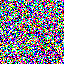

In [25]:
import copy

cloned_noise = copy.deepcopy(noise)


# Sample from the base model.
our_model.del_cache()
samples = diffusion.p_sample_loop(
    our_model_fn,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
    noise=cloned_noise
)[:batch_size]
our_model.del_cache()

# Show the output
show_images(samples)

100%|██████████| 2/2 [00:12<00:00,  6.10s/it]


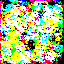

In [26]:
import copy

cloned_noise = copy.deepcopy(noise)


# Sample from the base model.
ref_model.del_cache()
samples = diffusion.p_sample_loop(
    ref_model_fn,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
    noise=cloned_noise
)[:batch_size]
ref_model.del_cache()

# Show the output
show_images(samples)

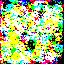

In [35]:
# Breaking down p_sample_loop part 1

import copy

cloned_noise = copy.deepcopy(noise)

# Sample from the base model.
ref_model.del_cache()
# samples = diffusion.p_sample_loop(
#     ref_model_fn,
#     (full_batch_size, 3, options["image_size"], options["image_size"]),
#     device=device,
#     clip_denoised=True,
#     progress=True,
#     model_kwargs=model_kwargs,
#     cond_fn=None,
#     noise=cloned_noise
# )[:batch_size]
final = None
for sample in diffusion.p_sample_loop_progressive(
    ref_model_fn,
    (2, 3, 64, 64),
    noise=cloned_noise,
    clip_denoised=False,
    denoised_fn=None,
    cond_fn=None,
    model_kwargs=model_kwargs,
    device='cpu',
):
    final = sample
sample = final['sample'][:batch_size]
ref_model.del_cache()

# Show the output
show_images(sample)

100%|██████████| 2/2 [00:12<00:00,  6.06s/it]


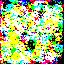

In [65]:
# Breaking down p_sample_loop part 2

th.manual_seed(2)
import random
random.seed(2)
np.random.seed(2)

import copy
from tqdm.auto import tqdm

cloned_noise = copy.deepcopy(noise)

# Sample from the base model.
ref_model.del_cache()

indices = list(range(2))[::-1]
img = cloned_noise
for i in tqdm(indices):
    t = th.tensor([i]*2)
    with th.no_grad():
        out = diffusion.p_sample(
            ref_model_fn,
            img,
            t,
            clip_denoised=False,
            denoised_fn=None,
            cond_fn=None,
            model_kwargs=model_kwargs,
        )
        img = out["sample"]
ref_model.del_cache()

# Show the output
show_images(sample)

100%|██████████| 2/2 [00:11<00:00,  5.81s/it]


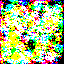

In [56]:
# Breaking down p_sample_loop part 3

cloned_noise = copy.deepcopy(noise)

# Sample from the base model.
ref_model.del_cache()
indices = list(range(2))[::-1]
img = cloned_noise
for i in tqdm(indices):
    t = th.tensor([i]*2)
    with th.no_grad():
        out = diffusion.p_mean_variance(
            ref_model_fn,
            img,
            t,
            clip_denoised=False,
            denoised_fn=None,
            model_kwargs=model_kwargs,
        )
        temp_noise = th.rand_like(img)
        nonzero_mask = (
            (t != 0).float().view(-1, *([1] * (len(img.shape) - 1)))
        )
        img = out["mean"] + nonzero_mask * th.exp(0.5 * out["log_variance"]) * noise
ref_model.del_cache()
img = img[:batch_size]

# Show the output
show_images(img)

In [55]:
import numpy as np
def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D numpy array for a batch of indices.

    :param arr: the 1-D numpy array.
    :param timesteps: a tensor of indices into the array to extract.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    res = th.from_numpy(arr).to(device=timesteps.device)[timesteps].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res + th.zeros(broadcast_shape, device=timesteps.device)


In [71]:
# p_mean_variance version 1

def p_mean_variance(model, x, t, clip_denoised=False, denoised_fn=None, model_kwargs=None):
        """
        Apply the model to get p(x_{t-1} | x_t), as well as a prediction of
        the initial x, x_0.

        :param model: the model, which takes a signal and a batch of timesteps
                      as input.
        :param x: the [N x C x ...] tensor at time t.
        :param t: a 1-D Tensor of timesteps.
        :param clip_denoised: if True, clip the denoised signal into [-1, 1].
        :param denoised_fn: if not None, a function which applies to the
            x_start prediction before it is used to sample. Applies before
            clip_denoised.
        :param model_kwargs: if not None, a dict of extra keyword arguments to
            pass to the model. This can be used for conditioning.
        :return: a dict with the following keys:
                 - 'mean': the model mean output.
                 - 'variance': the model variance output.
                 - 'log_variance': the log of 'variance'.
                 - 'pred_xstart': the prediction for x_0.
        """
        if model_kwargs is None:
            model_kwargs = {}

        B, C = x.shape[:2]
        assert t.shape == (B,)
        model_output = model(x, t, **model_kwargs)
        if isinstance(model_output, tuple):
            model_output, extra = model_output
        else:
            extra = None

        assert model_output.shape == (B, C * 2, *x.shape[2:])
        model_output, model_var_values = th.split(model_output, C, dim=1)
        min_log = _extract_into_tensor(diffusion.posterior_log_variance_clipped, t, x.shape)
        max_log = _extract_into_tensor(np.log(diffusion.betas), t, x.shape)
        # The model_var_values is [-1, 1] for [min_var, max_var].
        frac = (model_var_values + 1) / 2
        model_log_variance = frac * max_log + (1 - frac) * min_log
        model_variance = th.exp(model_log_variance)

        pred_xstart = diffusion._predict_xstart_from_eps(x_t=x, t=t, eps=model_output)
        model_mean, _, _ = diffusion.q_posterior_mean_variance(x_start=pred_xstart, x_t=x, t=t)

        assert model_mean.shape == model_log_variance.shape == pred_xstart.shape == x.shape
        return {
            "mean": model_mean,
            "variance": model_variance,
            "log_variance": model_log_variance,
            "pred_xstart": pred_xstart,
            "extra": extra,
        }

100%|██████████| 2/2 [00:12<00:00,  6.19s/it]


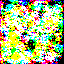

In [75]:
# Breaking down p_sample_loop part 4

cloned_noise = copy.deepcopy(noise)

# Sample from the base model.
ref_model.del_cache()
indices = list(range(2))[::-1]
img = cloned_noise
for i in tqdm(indices):
    t = th.tensor([i]*2)
    with th.no_grad():
        out = p_mean_variance(
            diffusion._wrap_model(ref_model_fn),
            img,
            t,
            clip_denoised=False,
            denoised_fn=None,
            model_kwargs=model_kwargs,
        )
        temp_noise = th.rand_like(img)
        nonzero_mask = (
            (t != 0).float().view(-1, *([1] * (len(img.shape) - 1)))
        )
        img = out["mean"] + nonzero_mask * th.exp(0.5 * out["log_variance"]) * temp_noise
ref_model.del_cache()
img = img[:batch_size]

# Show the output
show_images(img)

In [77]:
# p_mean_variance version 2

def p_mean_variance(model, x, t, clip_denoised=False, denoised_fn=None, model_kwargs=None):
    """
    Apply the model to get p(x_{t-1} | x_t), as well as a prediction of
    the initial x, x_0.

    :param model: the model, which takes a signal and a batch of timesteps
                    as input.
    :param x: the [N x C x ...] tensor at time t.
    :param t: a 1-D Tensor of timesteps.
    :param clip_denoised: if True, clip the denoised signal into [-1, 1].
    :param denoised_fn: if not None, a function which applies to the
        x_start prediction before it is used to sample. Applies before
        clip_denoised.
    :param model_kwargs: if not None, a dict of extra keyword arguments to
        pass to the model. This can be used for conditioning.
    :return: a dict with the following keys:
                - 'mean': the model mean output.
                - 'variance': the model variance output.
                - 'log_variance': the log of 'variance'.
                - 'pred_xstart': the prediction for x_0.
    """
    if model_kwargs is None:
        model_kwargs = {}

    B, C = x.shape[:2]
    assert t.shape == (B,)
    model_output = model(x, t, **model_kwargs)
    if isinstance(model_output, tuple):
        model_output, extra = model_output
    else:
        extra = None

    assert model_output.shape == (B, C * 2, *x.shape[2:])
    model_output, model_var_values = th.split(model_output, C, dim=1)
    min_log = _extract_into_tensor(diffusion.posterior_log_variance_clipped, t, x.shape)
    max_log = _extract_into_tensor(np.log(diffusion.betas), t, x.shape)
    # The model_var_values is [-1, 1] for [min_var, max_var].
    frac = (model_var_values + 1) / 2
    model_log_variance = frac * max_log + (1 - frac) * min_log
    model_variance = th.exp(model_log_variance)

    pred_xstart = diffusion._predict_xstart_from_eps(x_t=x, t=t, eps=model_output)
    model_mean, _, _ = diffusion.q_posterior_mean_variance(x_start=pred_xstart, x_t=x, t=t)

    assert model_mean.shape == model_log_variance.shape == pred_xstart.shape == x.shape
    return {
        "mean": model_mean,
        "variance": model_variance,
        "log_variance": model_log_variance,
        "pred_xstart": pred_xstart,
        "extra": extra,
    }

In [78]:
# Breaking down p_sample_loop part 5

cloned_noise = copy.deepcopy(noise)

# Sample from the base model.
ref_model.del_cache()
indices = list(range(2))[::-1]
img = cloned_noise
for i in tqdm(indices):
    t = th.tensor([i]*2)
    with th.no_grad():
        out = p_mean_variance(
            diffusion._wrap_model(ref_model_fn),
            img,
            t,
            clip_denoised=False,
            denoised_fn=None,
            model_kwargs=model_kwargs,
        )
        temp_noise = th.rand_like(img)
        nonzero_mask = (
            (t != 0).float().view(-1, *([1] * (len(img.shape) - 1)))
        )
        img = out["mean"] + nonzero_mask * th.exp(0.5 * out["log_variance"]) * temp_noise
ref_model.del_cache()
img = img[:batch_size]

# Show the output
show_images(img)

  0%|          | 0/2 [00:00<?, ?it/s]

yes
